---
### 6. K-means Clustering
- RFM 값만 추출하고, 분포를 확인. 
- 치우친 분포인 경우 log변환을 통해 정규분포에 가깝게 변환 
- scale 통일을 위해, 표준화 
- 최적의 k 찾기 (엘보분석, 실루엣 스코어)
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import koreanize_matplotlib
import warnings 
warnings.filterwarnings('ignore')

In [2]:
## 군집을 시각화 하기위한 패키지
#!pip install yellowbrick

In [3]:
## data loading, CustomerID 컬럼을 인덱스로 사용 
rfm = df = pd.read_csv('data/rfm.csv', index_col = 'CustomerID')
print(rfm.shape)
rfm.head(2)

(4338, 8)


,Recency,Frequency,Monetary,R,F,M,RFM_score,RFM_class
CustomerID,,,,,,,,
12346.0,326,1,77183.6,1,1,5,7,silver
12347.0,2,182,4310.0,5,5,5,15,platinum


In [4]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
 3   R          4338 non-null   int64  
 4   F          4338 non-null   int64  
 5   M          4338 non-null   int64  
 6   RFM_score  4338 non-null   int64  
 7   RFM_class  4338 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 305.0+ KB


---
### clustering을 위한 데이터 준비 
- 1) Recency,Frequency,Monetary 값만 추출 
- 2) 변수들의 분포 확인. 치우친 분포의 경우 정규분포에 가깝도록 변환 (log transform)
- 3) scale을 표준화 한다. 
---

In [5]:
## Recency,	Frequency, Monetary 변수만 추린다. 
rfm_cluster = rfm.iloc[:, :3]
rfm_cluster.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


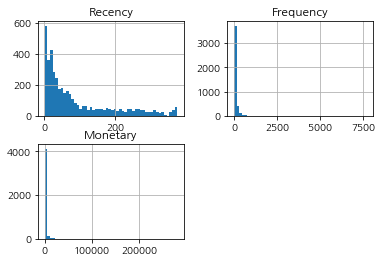

In [6]:
rfm_cluster.hist(bins=50) ;

---
#### 참고. 로그변환과 표준화 방법 
- log transform : 로그함수에서 x가 매우 작은 값일 경우 무한대에 가까운 음수가 된다. 
> 양수만을 취하기 위해 보통 log(x+1)을 사용한다. (* log(x+1) = log1p(x))
- 보통 변수를 표준화하면 모형의 성능이 개선된된다. 
> 1) StandardScaler : 평균을 표준편차로 나누어 준다. 
> 2) MinMaxScaler : 최소값 0, 최대값 1로 만듬. 값을 양수로 표현하려 할때 좋음 
> 3) RobustScaler : 중앙값을 0으로 만듬. outlier의 영향을 적게 받는 장점 
---

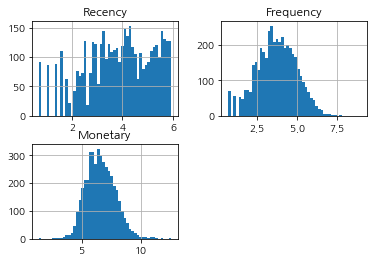

In [7]:
## 양수만을 취하기 위해 log1p()를 사용한다. (* log(x+1) = log1p(x))
rfm_cluster_log = np.log1p(rfm_cluster)
rfm_cluster_log.hist(bins=50) ;

In [8]:
## 모형의 성능 향상을 위해, StandardScaler로 표준화 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
ss = StandardScaler()
X = ss.fit_transform(rfm_cluster_log)

X = pd.DataFrame(X, columns = rfm_cluster_log.columns)
X

,Recency,Frequency,Monetary
0,1.461907,-2.437889,3.710308
1,-2.040527,1.188913,1.417102
2,0.372488,-0.211389,0.722104
3,-0.624188,0.461823,0.704363
4,1.424454,-0.673430,-0.612664
...,...,...,...
4333,1.343390,-1.068908,-1.100326
4334,1.024450,-1.324639,-1.734059
4335,-1.220333,-0.934757,-1.111567
4336,-1.659158,2.291117,0.824909


       Recency  Frequency  Monetary
count  4338.00    4338.00   4338.00
mean      0.00      -0.00     -0.00
std       1.00       1.00      1.00
min      -2.34      -2.44     -4.15
25%      -0.66      -0.67     -0.68
50%       0.09       0.01     -0.06
75%       0.85       0.70      0.66
max       1.56       4.19      4.74


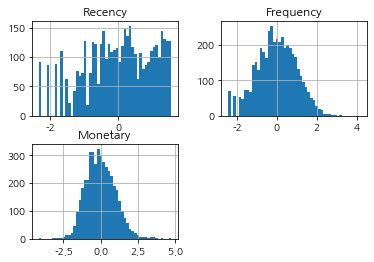

In [9]:
print(X.describe().round(2))
X.hist(bins=50) ;

- 로그변환과 표준화를 통해, RFM 모두 표준정규분포에 가까운 형태가 되었다. 

---
### K-means 옵션  
- n_cluster = : cluster의 갯수 지정, hyper parameter (default = 8)
- n_int = : 랜덤 초기회 횟수, 보통 auto로 지정 
- max_iter = : 반복횟수 지정 
---

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans.fit(X)

KMeans(random_state=42)

In [11]:
## kmeans.cluster_centers_ : 클러스터 각각의 센터값 (centroid)
## kmeans.inertia_ : 샘플과 센터값간의 거리, 클러스터 k의 변화에 따라 최소 inertia_를 찾는것이 관건
kmeans.cluster_centers_, kmeans.inertia_

(array([[ 1.02313003, -0.53321854, -0.57188148],
        [-0.26012544,  1.01292958,  0.96760373],
        [-0.25732831,  0.08489611, -0.14642299],
        [ 1.06463764, -1.5693088 , -1.37485967],
        [-1.50868552,  0.47093944,  0.41651721],
        [ 0.69847399,  0.25123556,  0.38184801],
        [-1.48310731,  1.65829437,  1.82484104],
        [-0.44474759, -0.98225545, -0.91338522]]),
 2727.7501667261668)

In [12]:
## kmeans.inertia_가 최소인 k값 찾기 
## 클러스터를 2~20개까지 만들어 보기 
inertia = []
silhouettes = []

for n_clusters in range(2,21) : 
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels = kmeans.labels_)) 
    print(n_clusters, end= ',') 

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,

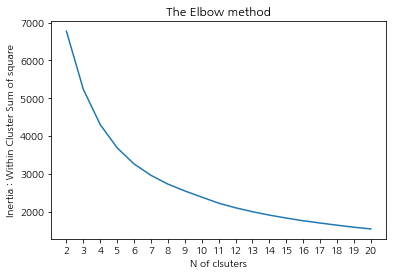

In [13]:
## elbow 분석 : k의 갯수에 따른 inertia의 변화 관찰 
plt.plot(range(2,21), inertia)
plt.title('The Elbow method')
plt.xlabel('N of clsuters')
plt.ylabel('Inertia : Within Cluster Sum of square')
plt.xticks(range(2,21))
plt.show()

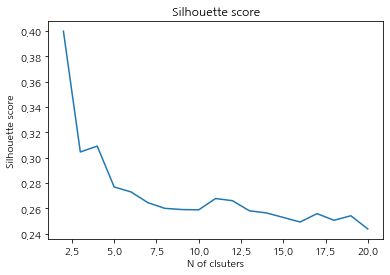

In [14]:
## 실루엣 계수: 각 샘플에 대해 같은 군집끼리의 밀집도와 다른 군집과의 떨어져있는 정도를 표현 
## -1 ~ 1 사이의 값을 가지며, 1에 가까울 수록 좋음 
plt.plot(range(2,21), silhouettes)
plt.title('Silhouette score')
plt.xlabel('N of clsuters')
plt.ylabel('Silhouette score')
plt.show()

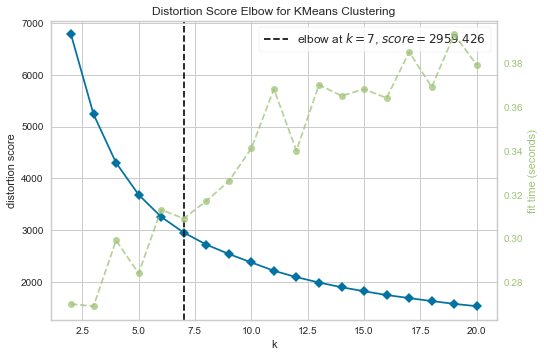

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
## yellow brick을 사용한 시각화 
from yellowbrick.cluster import KElbowVisualizer
KEV = KElbowVisualizer(kmeans, k=20)
KEV.fit(X)
KEV.show()

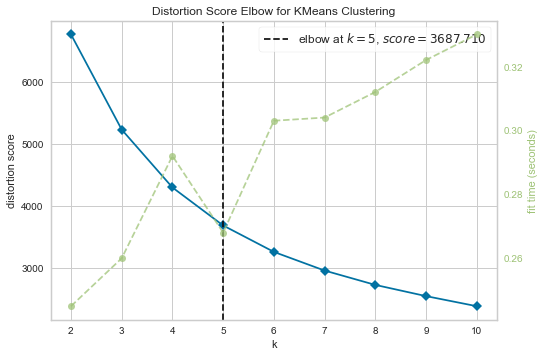

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
KEV = KElbowVisualizer(kmeans, k=10)
KEV.fit(X)
KEV.show()

- 최적의 클러스터 갯수가 hyperparameter값을 어떻게 지정해 주느냐에 따라 달라짐 

---
### 실전! : 현실적 문제로 클러스터를 silver, gold, platinum의 3개로 구분하고자 함 
- k=3으로 클러스터링 했을때, 타당한지 실루엣 스코어를 확인해보자 
---

In [17]:
n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [18]:
print(kmeans.labels_, '\n', kmeans.cluster_centers_)

[2 1 2 ... 0 1 2] 
 [[ 0.7780547  -0.96121043 -0.90765019]
 [-1.13786266  1.19225523  1.22449145]
 [-0.05060649  0.17512531  0.11331625]]


In [19]:
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3044084090284428

For n_clusters = 2 The average silhouette_score is : 0.3997147720511957
For n_clusters = 3 The average silhouette_score is : 0.30513802996817035
For n_clusters = 4 The average silhouette_score is : 0.3069639071000133
For n_clusters = 5 The average silhouette_score is : 0.276774613331342


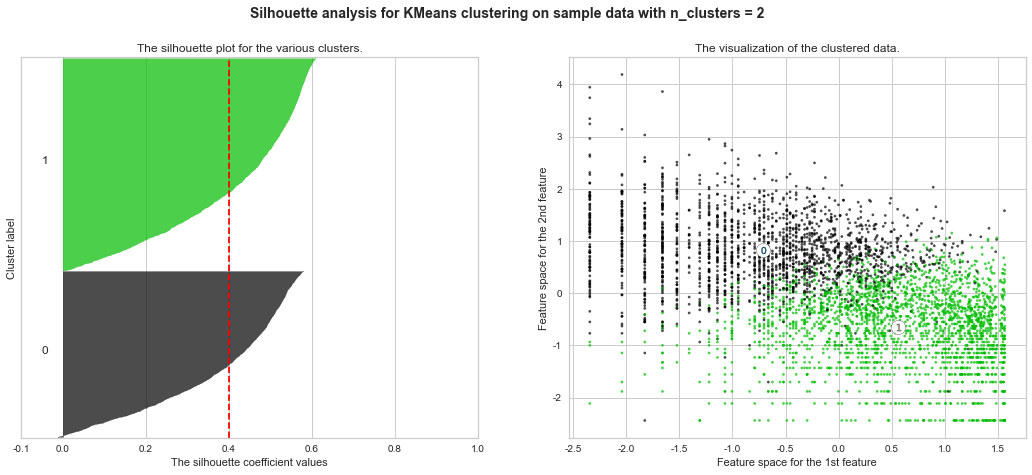

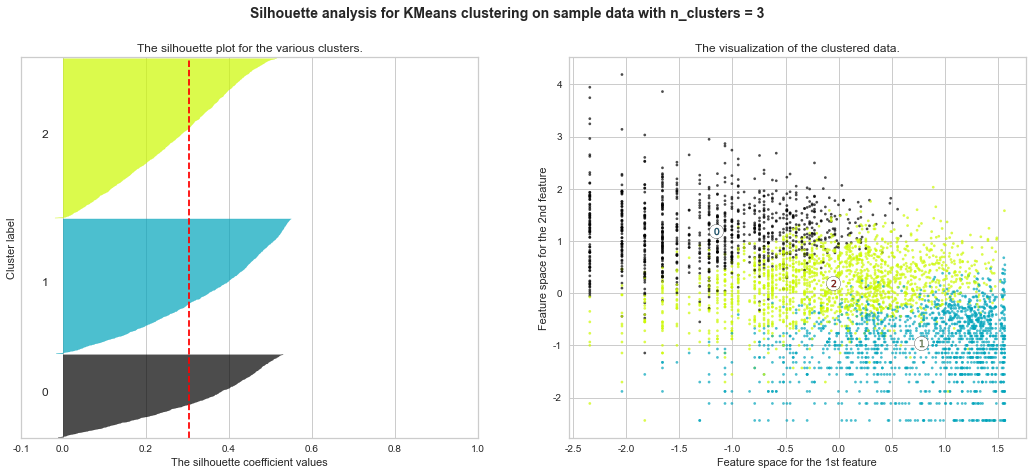

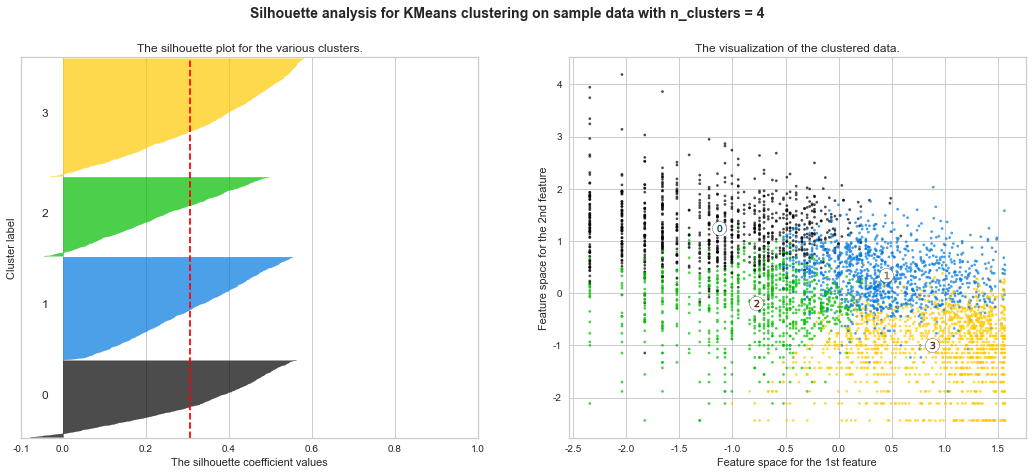

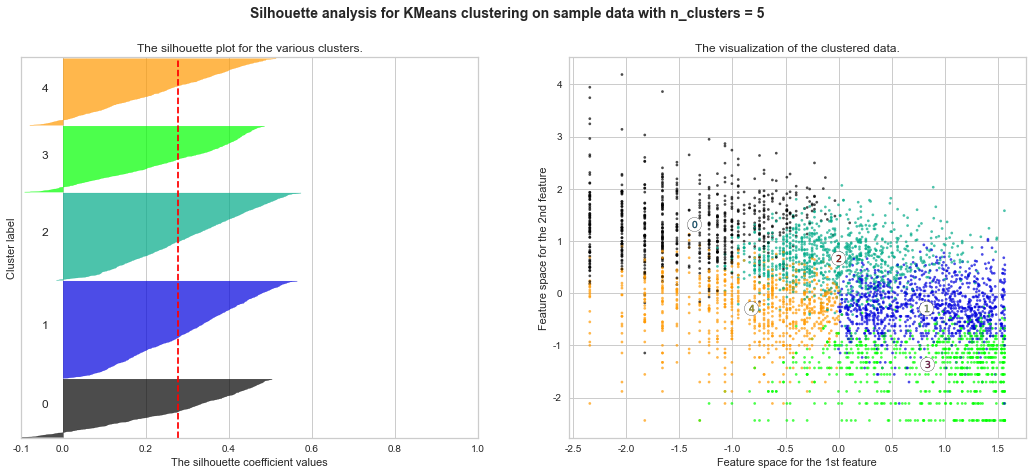

In [26]:
## 사이킷런의 예제코드 사용하여, k=3~5일때의 클러스터링 결과 비교 
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

- 조금 아쉽지만, 전반적으로 괜찮은 클러스터링이 이루어졌다. 
- k=3을 사용해도 괜찮아 보인다. 

In [21]:
## 데이터셋에 클러스터링 결과 컬럼 추가 
rfm['Cluster'] = kmeans.labels_
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_score,RFM_class,Cluster
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,7,silver,2
12347.0,2,182,4310.00,5,5,5,15,platinum,1
12348.0,75,31,1797.24,2,3,4,9,gold,2
12349.0,19,73,1757.55,4,4,4,12,platinum,2
12350.0,310,17,334.40,1,2,2,5,silver,0
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,silver,0
18281.0,181,7,80.82,1,1,1,3,silver,0
18282.0,8,12,178.05,5,1,1,7,silver,0


In [22]:
pd.crosstab(rfm['RFM_class'], rfm['Cluster'])

Cluster,0,1,2
RFM_class,,,
gold,25,16,1368
platinum,0,954,307
silver,1511,0,157


- 이전의 RFM 분석에 의한 구분과, 머신러닝(KMeans)에 의한 구분이 약간 다르긴 하나 전반적으로 비슷하다.
- 변수가 매우 많은 경우 qcut 등으로 일일이 전처리 해야하는 수고에 비하면, 머신러닝이 더 좋은 방법인듯

In [23]:
#########################################################################################

In [24]:
## 참고. 아래는 모터스 클러스터링에 사용했던 코드 적용 (k = 3~5)
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

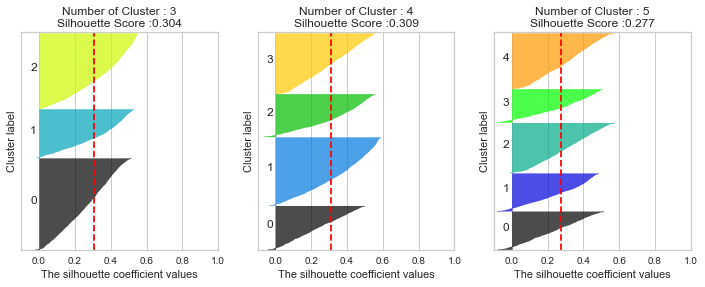

In [25]:
visualize_silhouette([3,4,5], X)